# Исследование работы сервиса аренды самокатов GoFast

В данном проекте будет проведён анализ работы сервиса аренды самокатов GoFast. В распоряжении имеется информация о пользователях, их поездках и подписках.
При имеющихся данных о некоторых пользователях из нескольких городов и об их поездках будут проверены гипотезы, которые могут помочь бизнесу вырасти. 

Краткий план работы:
1. Изучение общей информации
2. Предобработка данных
3. Исследовательский анализ данных: описание и визуализация общей информации о пользователях и поездках
4. Объединение данных о пользователях, поездках и подписках
5. Подсчёт выручки
6. Проверка некоторых гипотез для увеличения количества пользователей с подпиской

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
display(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
rides = pd.read_csv('/datasets/rides_go.csv')
display(rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

display(subscriptions)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


На данном этапе была изучена общая информация о пользователях, об их поездках и о подписках сервиса GoFast. Наименования столбцов корректны, данные представлены достаточно полно, однако на этапе предобработки предстоит исправить тип данных столбца date датафрейма rides. 

#### Шаг 2. Предобработка данных

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')
print(rides['date'])

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]


In [9]:
rides['month'] = rides['date'].dt.month
rides['year'] = rides['date'].dt.year
print(rides['year'].unique()) 
rides = rides.drop('year', axis=1) #удалим столбец year, тк он более не нужен
display(rides)

[2021]


,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


Видим, что в нашем распоряжении только данные за 2021 год

In [10]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [12]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропущенные значения отсутствуют

In [13]:
print(users.duplicated().sum()) 
users_new = users.drop_duplicates().reset_index(drop=True)
print(users_new) #в дальнейшем будет работа именно с этим преобразованным датасетом

31
      user_id        name  age            city subscription_type
0           1        Кира   22          Тюмень             ultra
1           2   Станислав   31            Омск             ultra
2           3     Алексей   20          Москва             ultra
3           4  Константин   26  Ростов-на-Дону             ultra
4           5       Адель   28            Омск             ultra
...       ...         ...  ...             ...               ...
1529     1530   Ростислав   29            Сочи              free
1530     1531      Никита   25       Пятигорск              free
1531     1532     Алексей   26          Тюмень              free
1532     1533      Степан   22       Краснодар              free
1533     1534     Альберт   25       Краснодар              free

[1534 rows x 5 columns]


Логично предположить, что раз в столбце user_id содержится уникальный идентификатор, то значения в нём повторяться не должны.
Создадим новый датафрейм users_new, преобразованный от датафрейма users

На данном этапе была проведена предобработка данных: найдены пропуски в данных, а точнее, их отсутствие; преобразованы типы данных для некоторых столбцов для удобства в дальнейшей работе, устранены дубликаты (удалены строки в датафрейме users с одинаковыми значениями в столбце user_id).

#### Шаг 3. Исследовательский анализ данных

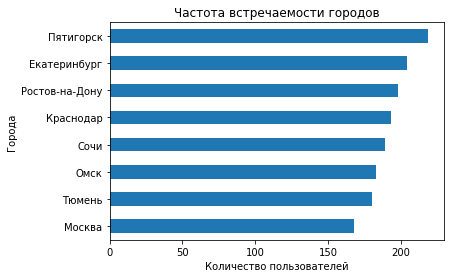

In [14]:
users_new['city'].value_counts(ascending=True).plot.barh() 
plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.show()

In [15]:
users_new.groupby('city')['user_id'].count()

city
Екатеринбург      204
Краснодар         193
Москва            168
Омск              183
Пятигорск         219
Ростов-на-Дону    198
Сочи              189
Тюмень            180
Name: user_id, dtype: int64

Разницы в количестве пользователей из разных городов не критичны между собой: к примеру, больше всего людей приходится на Пятигорск (204 человека), меньше всего - на Москву (168 человек).

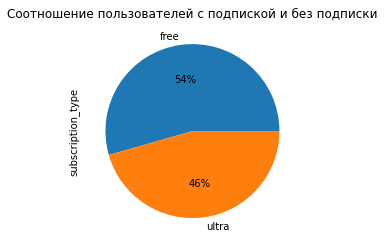

In [16]:
users_new['subscription_type'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Разница в количестве пользователей, пользующихся подпиской ultra или free, также не очень высока, однако всё же пользователей по подписке free больше (54% от общего количества), чем по подписке ultra (46%).

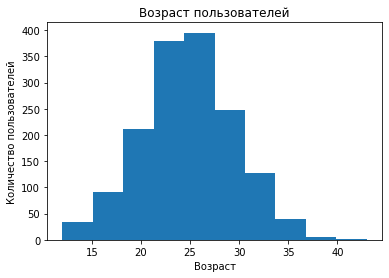

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [17]:
users_new['age'].plot(kind='hist') 
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

users_new['age'].describe()

Больше всего пользователей относятся к возрасту 24-28 лет (около 390 человек), чуть меньше - 21-24 года (около 380 человек) (в целом, обе возрастные группы можно отнести к одной: пользователи 20-30 лет, на них приходится примерно половина всех пользователей); примерно 16% пользователей - люди около 30 лет; примерно 15% - около 20 лет; примерно 8% - около 30-34; примерно 6% - около 15-18 лет; наконец, совсем небольшой процент (около 5%) приходится на людей около 35 лет и детей от 12 до 15 лет; пользователей около 40 лет и старше практически не встретить (максимальный встречающийся возраст - 43 года). 

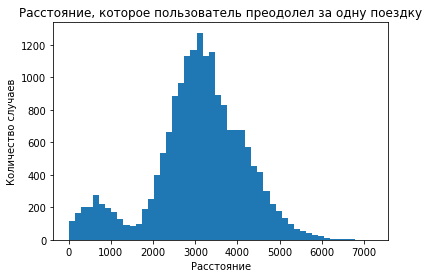

In [18]:
rides['distance'].plot(kind='hist', bins=50) 
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние')
plt.ylabel('Количество случаев')
plt.show()

Чаще всего (примерно 4000 раз, т.е. около 22%) пользователь за 1 поездку преодолевал расстояние примерно в 3000-3300 м, около 18% приходится на расстояние примерно 2200-3000 м, около 16% - примерно 3300-3800 м, около 12% - примерно 3800-4300 м, около 9% - примерно 1900-2200 м, около 7% - примерно 4300-4800 м, совсем небольшие доли (по меньше, чем 5%) - на расстояния до 1900 м и свыше 4000 м. 

In [19]:
rides.loc[rides['distance'] < 1, 'duration']

11555    10.001902
Name: duration, dtype: float64

Заметим, что на графике есть странный пик около 0 метров . Количество поездок с таким расстоянием крайне мало, однако оно всё-таки есть, поэтому его стоит обработать. С чем может быть связана такое маленькое пройденное расстояние? Скорее всего, это поездка, которую пользователь так и не совершил - предположительно, человек мог нажать случайно кнопку "Начать поездку", не проехать, а отменить поездку только через какое-то время. 

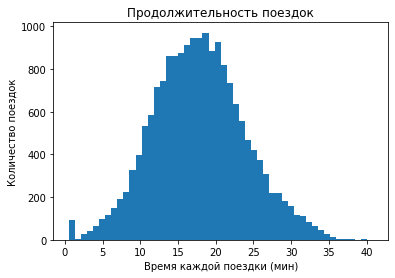

In [20]:
rides['duration'].plot(kind='hist', bins=50) 
plt.title('Продолжительность поездок')
plt.xlabel('Время каждой поездки (мин)')
plt.ylabel('Количество поездок')
plt.show()

Чаще всего (около 18% раз) пользователь за 1 поездку проезжал примерно 17-19 минут, около 16% - примерно 14-17 минут, около 15% - примерно 19-22 минут, около 13% - примерно 11-14 минут, около 10% - примерно 22-24 минут, около 8% - примерно 9-11 минут, около 6% - примерно 24-27 минут, совсем небольшие доли (по меньше, чем 5%) - приходятся на непродолжительные поездки менее 10 минут или длительные (от получаса и более). 

Заметим, что на графике есть странный пик около 0 минут (примерно 0,5 минуты). Количество поездок с таким временем мало (около 100 случаев), однако оно всё-таки есть, поэтому его стоит обработать. 
С чем может быть связана такая "непродолжительная" поездка? Скорее всего, информация о поездке (т.е. её длительность) могла записаться некорректно: пользователь мог проехать какое-то время, однако в данных информация о времени не сохранилась. 

In [21]:
print(rides.loc[rides['duration'] < 1, 'distance'])

6531     4196.445201
6570     4830.824371
6680     4684.004397
6695     5215.642710
6768     5197.436649
            ...     
17004    5531.335845
17242    6724.932981
17314    4445.481070
17505    5722.551787
17909    4103.998874
Name: distance, Length: 95, dtype: float64


На данном этапе был проведён исследовательский анализ данных:
1. изучена частота встречаемости городов;
2. определено соотношение пользователей с подпиской и без подписки;
3. изучен возраст пользователей;
4. изучено расстояние, которое пользователь преодолел за одну поездку;
5. изучена продолжительность поездок.

#### Шаг 4. Объединение данных

In [22]:
data = users_new.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')
display(data)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [23]:
print(len(rides) == len(data)) #ничего из информации не потеряно/не добавлено

True


In [24]:
data.isna().sum() #пропущенные значения отсутствуют

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [25]:
users_with_subscription = data[data['subscription_type'] == 'ultra']
users_without_subscription = data[data['subscription_type'] == 'free']

display(users_with_subscription)
print()
display(users_without_subscription)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


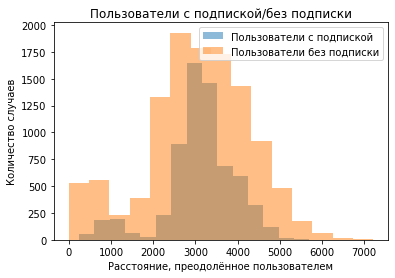

In [26]:
plt.hist(users_with_subscription['distance'], alpha=0.5, label='Пользователи с подпиской', bins=15)
plt.hist(users_without_subscription['distance'], alpha=0.5, label='Пользователи без подписки', bins=15)

plt.legend()
plt.title('Пользователи с подпиской/без подписки')
plt.xlabel('Расстояние, преодолённое пользователем')
plt.ylabel('Количество случаев')
plt.show()

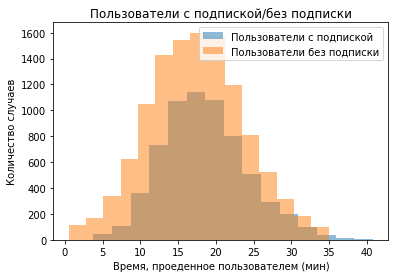

In [27]:
plt.hist(users_with_subscription['duration'], alpha=0.5, label='Пользователи с подпиской', bins=15)
plt.hist(users_without_subscription['duration'], alpha=0.5, label='Пользователи без подписки', bins=15)

plt.legend()
plt.title('Пользователи с подпиской/без подписки')
plt.xlabel('Время, проеденное пользователем (мин)')
plt.ylabel('Количество случаев')
plt.show()

Сравнив получившиеся гистограммы, видим, что особого различия в поведении 2 групп пользователей нет. 

На данном этапе было проведено объединение данных о пользователях, поездках и подписках в единый датафрейм, а также для сравнения и удобства были созданы два датафрейма для каждой из групп пользователей - с подпиской и без подписки. 

#### Шаг 5. Подсчёт выручки

In [28]:
data['duration'] = np.ceil(data['duration'])

In [29]:
data['rides_amount'] = data['month']

In [30]:
data_final = pd.DataFrame()
distance_sum = data.pivot_table(index=['user_id', 'month'], values='distance', aggfunc='sum')
duration_sum = data.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
rides_amount = data.pivot_table(index=['user_id', 'month'], values='rides_amount', aggfunc='count')
minute_price = data.pivot_table(index=['user_id', 'month'], values='minute_price', aggfunc='first')
start_ride_price = data.pivot_table(index=['user_id', 'month'], values='start_ride_price', aggfunc='first')
subscription_fee = data.pivot_table(index=['user_id', 'month'], values='subscription_fee', aggfunc='first')
subscription_type = data.pivot_table(index=['user_id', 'month'], values='subscription_type', aggfunc='first')

data_final = (
                distance_sum.merge(duration_sum, on=['user_id', 'month'])
                .merge(rides_amount, on=['user_id', 'month'])
                .merge(minute_price, on=['user_id', 'month'])
                .merge(start_ride_price, on=['user_id', 'month'])
                .merge(subscription_fee, on=['user_id', 'month'])
                .merge(subscription_type, on=['user_id', 'month'])
             )
display(data_final)

distance  duration  rides_amount  minute_price  \
user_id month                                                       
1       1       7027.511294      42.0             2             6   
        4        754.159807       7.0             1             6   
        8       6723.470560      46.0             2             6   
        10      5809.911100      32.0             2             6   
        11      7003.499363      56.0             3             6   
...                     ...       ...           ...           ...   
1534    6       3409.468534      26.0             2             8   
        8       7622.453034      48.0             2             8   
        9       4928.173852      23.0             1             8   
        11     13350.015305      78.0             4             8   
        12      2371.711192      16.0             1             8   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra  
...                         ...               ...               ...  
1534    6                    50                 0              free  
        8                    50                 0              free  
        9                    50                 0              free  
        11                   50                 0              free  
        12                   50                 0              free  

[11331 rows x 7 columns]

In [31]:
data_final['income'] = data_final['start_ride_price'] * data_final['rides_amount'] \
                       + data_final['minute_price'] * data_final['duration'] + data_final['subscription_fee']
display(data_final)

distance  duration  rides_amount  minute_price  \
user_id month                                                       
1       1       7027.511294      42.0             2             6   
        4        754.159807       7.0             1             6   
        8       6723.470560      46.0             2             6   
        10      5809.911100      32.0             2             6   
        11      7003.499363      56.0             3             6   
...                     ...       ...           ...           ...   
1534    6       3409.468534      26.0             2             8   
        8       7622.453034      48.0             2             8   
        9       4928.173852      23.0             1             8   
        11     13350.015305      78.0             4             8   
        12      2371.711192      16.0             1             8   

               start_ride_price  subscription_fee subscription_type  income  
user_id month                                                                
1       1                     0               199             ultra   451.0  
        4                     0               199             ultra   241.0  
        8                     0               199             ultra   475.0  
        10                    0               199             ultra   391.0  
        11                    0               199             ultra   535.0  
...                         ...               ...               ...     ...  
1534    6                    50                 0              free   308.0  
        8                    50                 0              free   484.0  
        9                    50                 0              free   234.0  
        11                   50                 0              free   824.0  
        12                   50                 0              free   178.0  

[11331 rows x 8 columns]

На данном этапе был проведён подсчёт выручки. 

#### Шаг 6. Проверка гипотез

Первая гипотеза: тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза: пользователи с подпиской тратят столько же времени на поездки, сколько и пользователи без подписки. 

Альтернативная гипотеза: пользователи с подпиской тратят на поездки больше времени, чем пользователи без поездки. 

In [32]:
print(f'Среднее значение продолжительности поездок пользователей с подпиской: {np.mean(users_with_subscription["duration"])}')
print(f'Среднее значение продолжительности поездок пользователей без подписки: {np.mean(users_without_subscription["duration"])}')
alpha = 0.05
results_1 = st.ttest_ind(
    users_with_subscription['duration'], users_without_subscription['duration'], alternative='greater')
print('p-значение:', results_1.pvalue)
if results_1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее значение продолжительности поездок пользователей с подпиской: 18.54198516280583
Среднее значение продолжительности поездок пользователей без подписки: 17.39090929866399
p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Можно сделать вывод о том, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без поездки. 

Вторая гипотеза: можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Нулевая гипотеза: пользователи с подпиской за одну поездку проезжают в среднем 3130 метров. 

Альтернативная гипотеза: пользователи с подпиской за одну поездку проезжают более 3130 метров. 

In [33]:
print(f'Среднее значение расстояния, которое проезжает за 1 поездку пользователь с подпиской: {np.mean(users_with_subscription["distance"])}')
alpha = 0.05
value = 3130
results_2 = st.ttest_1samp(
    users_with_subscription["distance"], value, alternative='greater')
print('p-значение:', results_2.pvalue)
if results_2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее значение расстояния, которое проезжает за 1 поездку пользователь с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Можно сделать вывод о том, что расстояние, которое в среднем проезжают пользователи с подпиской за поездку, не превышает оптимального расстояния 3130 метров.

Третья гипотеза: будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. 

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [34]:
print(f'Среднее значение помесячной выручки от пользователей с подпиской: {np.mean(data_final.loc[data_final["subscription_type"] == "ultra", "income"])}')
print(f'Среднее значение помесячной выручки от пользователей без подписки: {np.mean(data_final.loc[data_final["subscription_type"] == "free", "income"])}')
alpha = 0.05

results_3 = st.ttest_ind(
    data_final.loc[data_final['subscription_type'] == 'ultra', 'income'], 
    data_final.loc[data_final['subscription_type'] == 'free', 'income'], 
    alternative='greater')
print('p-значение:', results_3.pvalue)
if results_3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее значение помесячной выручки от пользователей с подпиской: 362.7921906022502
Среднее значение помесячной выручки от пользователей без подписки: 328.6413651073845
p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Можно сделать вывод о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Четвёртая гипотеза: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Изменилось ли количество обращений в техподдержку после обновления серверов?

Нулевая гипотеза: количество обращений в техподдержку до и после обновления серверов одинаково. 

Альтернативная гипотеза: количество обращений в техподдержку после обновления серверов значительно снизилось. 

Для проверки данной гипотезы будем использовать двухвыборочный t-тест для зависимых выборок. Выборки являются между собой зависимыми, тк рассматривается выборка ДО обновления серверов и выборка ПОСЛЕ изменения. Для проверки гипотезы будем применять метод ttest_rel из библиотеки scipy_stats, а в аргументы методу передадим наборы данных - рассматриваемые парные выборки.

#### Общий вывод

В данном проекте был проведён анализ работы сервиса аренды самокатов GoFast:
1. Была изучена информация о пользователях, их поездках и подписках. 
2. Далее была проведена предобработка данных: выявлено отсутствие пропусков в данных; преобразованы типы данных для некоторых столбцов для удобства в дальнейшей работе, устранены дубликаты. 
3. После этого был выполнен исследовательский анализ данных: изучена частота встречаемости городов; определено соотношение пользователей с подпиской и без подписки; изучен возраст пользователей; изучено расстояние, которое пользователь преодолел за одну поездку; изучена продолжительность поездок.
4. Затем было проведено объединение данных о пользователях, поездках и подписках в единый датафрейм, а также для сравнения и удобства были созданы два датафрейма для каждой из групп пользователей - с подпиской и без подписки.
5. Был проведён подсчёт выручки.
6. На финальном этапе были проверены несколько гипотез: выявлено, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без поездки; расстояние, которое в среднем проезжают пользователи с подпиской за поездку, не превышает оптимального расстояния 3130 метров; помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки; дан ответ на вопрос, какой тест нужно использовать для проверки гипотезы, в которой рассматриваются парные выборки. 

В итоге выяснено, что пользователи с подпиской являются более выгодными для компании, тк они тратят на поездки больше времени и помесячная выручка от них выше. 